---

_You are currently looking at **version 1.1** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-machine-learning/resources/bANLa) course resource._

---

## Assignment 4 - Understanding and Predicting Property Maintenance Fines

This assignment is based on a data challenge from the Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)). 

The Michigan Data Science Team ([MDST](http://midas.umich.edu/mdst/)) and the Michigan Student Symposium for Interdisciplinary Statistical Sciences ([MSSISS](https://sites.lsa.umich.edu/mssiss/)) have partnered with the City of Detroit to help solve one of the most pressing problems facing Detroit - blight. [Blight violations](http://www.detroitmi.gov/How-Do-I/Report/Blight-Complaint-FAQs) are issued by the city to individuals who allow their properties to remain in a deteriorated condition. Every year, the city of Detroit issues millions of dollars in fines to residents and every year, many of these fines remain unpaid. Enforcing unpaid blight fines is a costly and tedious process, so the city wants to know: how can we increase blight ticket compliance?

The first step in answering this question is understanding when and why a resident might fail to comply with a blight ticket. This is where predictive modeling comes in. For this assignment, your task is to predict whether a given blight ticket will be paid on time.

All data for this assignment has been provided to us through the [Detroit Open Data Portal](https://data.detroitmi.gov/). **Only the data already included in your Coursera directory can be used for training the model for this assignment.** Nonetheless, we encourage you to look into data from other Detroit datasets to help inform feature creation and model selection. We recommend taking a look at the following related datasets:

* [Building Permits](https://data.detroitmi.gov/Property-Parcels/Building-Permits/xw2a-a7tf)
* [Trades Permits](https://data.detroitmi.gov/Property-Parcels/Trades-Permits/635b-dsgv)
* [Improve Detroit: Submitted Issues](https://data.detroitmi.gov/Government/Improve-Detroit-Submitted-Issues/fwz3-w3yn)
* [DPD: Citizen Complaints](https://data.detroitmi.gov/Public-Safety/DPD-Citizen-Complaints-2016/kahe-efs3)
* [Parcel Map](https://data.detroitmi.gov/Property-Parcels/Parcel-Map/fxkw-udwf)

___

We provide you with two data files for use in training and validating your models: train.csv and test.csv. Each row in these two files corresponds to a single blight ticket, and includes information about when, why, and to whom each ticket was issued. The target variable is compliance, which is True if the ticket was paid early, on time, or within one month of the hearing data, False if the ticket was paid after the hearing date or not at all, and Null if the violator was found not responsible. Compliance, as well as a handful of other variables that will not be available at test-time, are only included in train.csv.

Note: All tickets where the violators were found not responsible are not considered during evaluation. They are included in the training set as an additional source of data for visualization, and to enable unsupervised and semi-supervised approaches. However, they are not included in the test set.

<br>

**File descriptions** (Use only this data for training your model!)

    readonly/train.csv - the training set (all tickets issued 2004-2011)
    readonly/test.csv - the test set (all tickets issued 2012-2016)
    readonly/addresses.csv & readonly/latlons.csv - mapping from ticket id to addresses, and from addresses to lat/lon coordinates. 
     Note: misspelled addresses may be incorrectly geolocated.

<br>

**Data fields**

train.csv & test.csv

    ticket_id - unique identifier for tickets
    agency_name - Agency that issued the ticket
    inspector_name - Name of inspector that issued the ticket
    violator_name - Name of the person/organization that the ticket was issued to
    violation_street_number, violation_street_name, violation_zip_code - Address where the violation occurred
    mailing_address_str_number, mailing_address_str_name, city, state, zip_code, non_us_str_code, country - Mailing address of the violator
    ticket_issued_date - Date and time the ticket was issued
    hearing_date - Date and time the violator's hearing was scheduled
    violation_code, violation_description - Type of violation
    disposition - Judgment and judgement type
    fine_amount - Violation fine amount, excluding fees
    admin_fee - $20 fee assigned to responsible judgments
state_fee - $10 fee assigned to responsible judgments
    late_fee - 10% fee assigned to responsible judgments
    discount_amount - discount applied, if any
    clean_up_cost - DPW clean-up or graffiti removal cost
    judgment_amount - Sum of all fines and fees
    grafitti_status - Flag for graffiti violations
    
train.csv only

    payment_amount - Amount paid, if any
    payment_date - Date payment was made, if it was received
    payment_status - Current payment status as of Feb 1 2017
    balance_due - Fines and fees still owed
    collection_status - Flag for payments in collections
    compliance [target variable for prediction] 
     Null = Not responsible
     0 = Responsible, non-compliant
     1 = Responsible, compliant
    compliance_detail - More information on why each ticket was marked compliant or non-compliant


___

## Evaluation

Your predictions will be given as the probability that the corresponding blight ticket will be paid on time.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC). 

Your grade will be based on the AUC score computed for your classifier. A model which with an AUROC of 0.7 passes this assignment, over 0.75 will recieve full points.
___

For this assignment, create a function that trains a model to predict blight ticket compliance in Detroit using `readonly/train.csv`. Using this model, return a series of length 61001 with the data being the probability that each corresponding ticket from `readonly/test.csv` will be paid, and the index being the ticket_id.

Example:

    ticket_id
       284932    0.531842
       285362    0.401958
       285361    0.105928
       285338    0.018572
                 ...
       376499    0.208567
       376500    0.818759
       369851    0.018528
       Name: compliance, dtype: float32
       
### Hints

* Make sure your code is working before submitting it to the autograder.

* Print out your result to see whether there is anything weird (e.g., all probabilities are the same).

* Generally the total runtime should be less than 10 mins. You should NOT use Neural Network related classifiers (e.g., MLPClassifier) in this question. 

* Try to avoid global variables. If you have other functions besides blight_model, you should move those functions inside the scope of blight_model.

* Refer to the pinned threads in Week 4's discussion forum when there is something you could not figure it out.

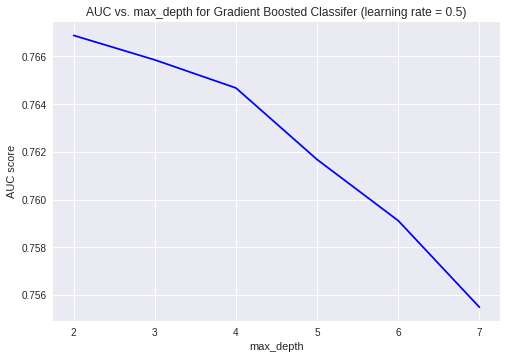

In [8]:
def blight_model():
    
    import sys
    import warnings

    if not sys.warnoptions:                       # ignore minor warnings while code is running
        warnings.simplefilter("ignore")
    
    import pandas as pd
    import numpy as np
    import datetime as dt
    import matplotlib.pyplot as plt

    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.metrics import confusion_matrix,roc_curve, auc
    from adspy_shared_utilities import plot_class_regions_for_classifier
    
    train = pd.read_csv('train.csv',engine='python')
    
    # Select the columns in the train dataset that we will keep
    
    cols_to_keep = ['ticket_id','zip_code','violation_code','judgment_amount','compliance_detail','compliance']
    train = train[cols_to_keep]
    
    # Set 'ticket_id' as the row index
    
    train.set_index('ticket_id',inplace=True)
    
    # Delete rows in 'train' where no violation has occurred

    train = train[(train['compliance_detail'] != 'not responsible by disposition') & 
                  (train['compliance_detail'] != 'not responsible by pending judgment disposition')]
    
    # Clean up the target 'compliance' column
    
    train['compliance'] = 1 
    non_compliant = train['compliance_detail'].str.contains('non-compliant',regex=False)
    train['compliance'][non_compliant] = 0
    
    # Now we can get rid of the 'compliance_detail' column
    
    train.drop('compliance_detail', axis=1, inplace=True)
    
    # Recode the 'zip_code' column 
    
    train['zip_code'] = train['zip_code'].astype('str')
    
    # Find all rows where zip code does not start with '48'
    
    def recode_odd_ball_zips(df):
    
        good_zips = ['48227','48221','48235','48228','48219','48238','48224','48205',
                 '48204','48234','48206','48213','48223','48209','48203','48075',
                 '48210','48207','48202','48076','48214','48226','48212','48037',
                 '48034','48215','48237','48208','48126','48201','48126']
    
        odd_ball_zips = df.loc[~df['zip_code'].str.startswith(('48'))]  
    
        increment = int(len(odd_ball_zips)/len(good_zips))+1
    
        for i,zip_code in enumerate(good_zips):                             # populate 'rows['zip_code]' with zip codes from 'good_zips'
            odd_ball_zips['zip_code'][increment*i:increment*(i+1)] = zip_code
        
        df.update(odd_ball_zips)                                             # update the dataset with the recoded zip codes.
        
        return df
    
    train = recode_odd_ball_zips(train)

    # Convert columns of strings to coded categorical variables
    
    def categorical(series):
        series = series.astype('category')
        series = series.cat.codes
        return series
    
    train['zip_code'] = categorical(train['zip_code'])

    # Recode the 'violation_code' column and convert to coded categorical variable
    
    def recode_violation_code_column(df):
        
        df['violation_recode'] = 'other'
        code9_1 = df['violation_code'].str.startswith('9-1')
        df['violation_recode'][code9_1] = '9-1'
        code22_2 = df['violation_code'].str.startswith('22-2')
        df['violation_recode'][code22_2] = '22-2'
        code61 = df['violation_code'].str.startswith('61')
        df['violation_recode'][code61] = '61'
        code194 = df['violation_code'].str.startswith('194')
        df['violation_recode'][code194] = '194'
        df['violation_recode'] = df['violation_recode'].astype('category')
        df['violation_recode'] = df['violation_recode'].cat.codes
        df.drop('violation_code', axis=1, inplace=True)
        
        return df
    
    train = recode_violation_code_column(train)
    
    # Create the X and y dataframes
    
    X = train.drop(['compliance'],axis=1)
    y = train['compliance']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # We must apply the scaling to the test set that we computed for the training set
    X_test_scaled = scaler.transform(X_test)
    
    # Set up the Gradient Boosting Classifier
    
    max_depth_values = [2,3,4,5,6,7]
    train_results = []
    
    for value in max_depth_values:
        clf = GradientBoostingClassifier(learning_rate=0.5,max_depth = value, random_state=0)
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
        y_score = clf.fit(X_train_scaled, y_train).decision_function(X_test_scaled)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
    
    
    from matplotlib.legend_handler import HandlerLine2D
    line1 = plt.plot(max_depth_values, train_results, 'b',label= 'Train AUC')
    # plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.title('AUC vs. max_depth for Gradient Boosted Classifer (learning rate = 0.5)')
    plt.ylabel('AUC score')
    plt.xlabel('max_depth')
    plt.show()
    
    '''clf = GradientBoostingClassifier(random_state = 0)
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    confusion = confusion_matrix(y_test, y_pred)
    
    y_score = clf.fit(X_train_scaled, y_train).decision_function(X_test_scaled)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot(fpr, tpr, lw=3, label='ROC curve (area = {:0.2f})'.format(roc_auc))
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    # plt.axes().set_aspect('equal')
    plt.show()
    
    # Now, let's process the test dataset
    
    test = pd.read_csv('test.csv',engine='python')
    cols_to_keep = ['ticket_id','zip_code','violation_code','judgment_amount']
    test = test[cols_to_keep]
    
    ticket_id = test['ticket_id']                # save the 'ticket_id' column in test, we're going to need it later
    test.set_index('ticket_id',inplace=True)

    # Recode the 'zip_code' column
    
    test['zip_code'] = test['zip_code'].astype('str')
    test = recode_odd_ball_zips(test)
    test['zip_code'] = categorical(test['zip_code'])
    
    # Recode the 'violation_code' column
    
    test = recode_violation_code_column(test)
    
    # Min-Max scale the numerical variables
    
    test_scaled = scaler.fit_transform(test)
    
    # Now get the probabilities of a '1' outcome using the 'proba' function
    
    y_probs = clf.fit(X_train_scaled, y_train).predict_proba(test_scaled)
    
    compliance = pd.Series(y_probs[:,1], index = ticket_id)   # create a pandas Series with the ticket_id as index'''
    
    return

blight_model()